<a href="https://colab.research.google.com/github/matteobolner/AML_Basic/blob/master/AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LIBRARIES**

---






In [3]:
import scipy as sp
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import datetime as dt
import joblib
from urllib.request import urlopen
from numpy import set_printoptions
from scipy.ndimage import interpolation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC

  

**LOADING THE DATASET**

---




In [4]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

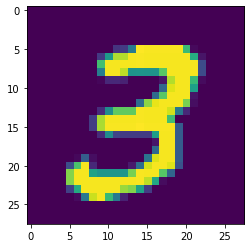

In [5]:
plt.imshow(X[7].reshape(28,28))

**DATA PREPROCESSING**

---

According to most literature available and the official MNIST website (http://yann.lecun.com/exdb/mnist/), most handwriting classification models based on Support Vector Machines (SVM) benefit from deskewing, that is the straightening of the numbers in the images.    
Therefore, all the images in the dataset were processed with deskewing, using the method available at https://fsix.github.io/mnist/Deskewing.html








In [6]:
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1])
    covariance_matrix = np.array([[m00,m01],[m01,m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


The results of deskewing can be appreciated in the images below

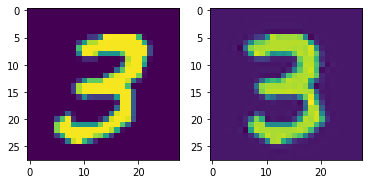

In [7]:
plt.subplot(1, 2, 1)
plt.imshow(X[7].reshape(28,28))

newim = deskew(X[7].reshape(28,28))
plt.subplot(1, 2, 2)
plt.imshow(newim)

In [8]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)

X_deskewed = deskewAll(X)

Each feature is then transformed by rescaling to a value between 0 and 1

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X_deskewed)

The dataset is split into training and testing sets, with a test size 15% of the total

In [10]:
x_train, x_test, y_train, y_test = train_test_split(rescaledX, y, test_size=0.3, random_state=42)
data = {"train": {"X": x_train, "Y": y_train}, "test": {"X": x_test, "Y": y_test},}

In [11]:
samplesize = len(data["train"]["X"])

**PARAMETER TUNING**


---

The main parameters considered in the tuning of the model are:


*   **C** -> Regularization parameter
*   **kernel** -> kernel type used in the algorithm
*   **gamma** -> kernel coefficient

In [12]:
gamma_range = [0.0001, 0.01, 1.0, 5]
C_range = [0.001, 0.1, 10, 50, 100]
kernels = ['rbf','poly']
degrees = [4,5]
parameters_rbf = {'kernel': ['rbf'], 'C':C_range, 'gamma': gamma_range, 'degree': degrees}
parameters_poly = {'kernel': ['rbf'], 'C':C_range, 'gamma': gamma_range, 'degree': degrees}


In [13]:
svm_clf = svm.SVC()
grid_clf_rbf = GridSearchCV(estimator=svm_clf,param_grid=parameters_rbf, cv = 3, n_jobs=7, verbose=10)
grid_clf_poly= GridSearchCV(estimator=svm_clf,param_grid=parameters_poly, cv = 3, n_jobs=7, verbose=10)

Grid search was performed on another machine due to time reasons; the grid classifiers were pickled and imported 

In [14]:
#grid_clf.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])

In [15]:
grid_clf_rbf = joblib.load(urlopen('https://github.com/matteobolner/AML_Basic/blob/master/grid_clf.pkl?raw=true'))
grid_clf_poly = joblib.load(urlopen('https://github.com/matteobolner/AML_Basic/blob/master/grid_clf_poly.pkl?raw=true'))


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
grid_clf_poly
#grid_clf_rbf

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=7,
             param_grid={'C': [0.1, 1, 10, 50, 100], 'degree': [4, 5],
                         'gamma': [0.0001, 0.01, 1.0, 10], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [17]:
classifier_rbf = grid_clf_rbf.best_estimator_
params_rbf = grid_clf_rbf.best_params_
scores_rbf = grid_clf_rbf.cv_results_['mean_test_score']
classifier_poly = grid_clf_poly.best_estimator_
params_poly = grid_clf_poly.best_params_
scores_poly = grid_clf_poly.cv_results_['mean_test_score']

In [18]:
print("Best performing rbf classifier:\n" + str(classifier_rbf))
print("\nBest rbf parameters:\n" + str(params_rbf))
print("\nAll rbf test scores:\n" + str(scores_rbf))
print("Best performing poly classifier:\n" + str(classifier_poly))
print("\nBest poly parameters:\n" + str(params_poly))
print("\nAll poly test scores:\n" + str(scores_poly))

Best performing rbf classifier:
SVC(C=50, break_ties=False, cache_size=1000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best rbf parameters:
{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}

All rbf test scores:
[0.55932651 0.95579592 0.19553059 0.1125102  0.91991842 0.97334695
 0.35477557 0.1125102  0.95091837 0.98218367 0.38485717 0.1125102
 0.96085716 0.98257143 0.38485717 0.1125102  0.96330613 0.98238776
 0.38485717 0.1125102 ]
Best performing poly classifier:
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best poly parameters:
{'C': 10, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}

All poly test scores:
[0.1125102  0.95585716 0.9815

In [19]:
#grid_clf.cv_results_

In [20]:
#predicted = grid_clf.predict(data["test"]["X"])
#print("Confusion matrix:\n%s" % metrics.confusion_matrix(data["test"]["Y"], predicted))
#print("Accuracy: %0.4f" % metrics.accuracy_score(data["test"]["Y"], predicted))


In [21]:
#print(sklearn.metrics.matthews_corrcoef(y_pred, data["test"]["Y"]))

In [22]:
rbf_params_df = pd.concat([pd.DataFrame(grid_clf_rbf.cv_results_["params"]),pd.DataFrame(grid_clf_rbf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [23]:
poly_params_df = pd.concat([pd.DataFrame(grid_clf_poly.cv_results_["params"]),pd.DataFrame(grid_clf_poly.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [24]:
print("Best parameters set found on training sets:")
print()
print(grid_clf_rbf.best_params_)
print(grid_clf_poly.best_params_)

Best parameters set found on training sets:

{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}
{'C': 10, 'degree': 4, 'gamma': 0.01, 'kernel': 'poly'}


In [25]:
#means = grid_clf.cv_results_['mean_test_score']
#stds = grid_clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
#  print("%0.3f (+/-%0.03f) with %r" % (mean, std * 2, params))

In [26]:
mnist_classifier_rbf = SVC(probability=False, kernel="rbf", C=50, gamma=0.01)
mnist_classifier_rbf.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])
mnist_classifier_poly = SVC(probability=False, kernel="poly", C=10, gamma=0.01, degree = 4)
mnist_classifier_poly.fit(data["train"]["X"][:samplesize], data["train"]["Y"][:samplesize])


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

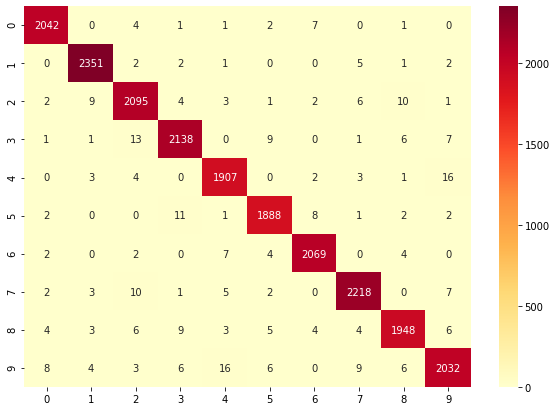

In [27]:
predicted_rbf = mnist_classifier_rbf.predict(data["test"]["X"])
conf_matrix_df_rbf = pd.DataFrame(metrics.confusion_matrix(data["test"]["Y"], predicted_rbf))
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix_df_rbf, annot=True, cmap="YlOrRd", fmt="d")

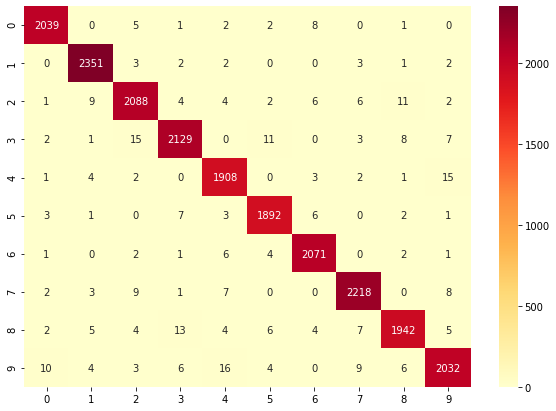

In [28]:
predicted_poly = mnist_classifier_poly.predict(data["test"]["X"])
conf_matrix_df_poly = pd.DataFrame(metrics.confusion_matrix(data["test"]["Y"], predicted_poly))
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix_df_poly, annot=True, cmap="YlOrRd", fmt="d")

In [35]:
error_rate_rbf = 100*(1 - metrics.accuracy_score(data["test"]["Y"], predicted_rbf))
error_rate_poly = 100*(1 - metrics.accuracy_score(data["test"]["Y"], predicted_poly))

print("Error rate with gaussian kernel: %0.4f"%error_rate_rbf)
print("Accuracy with gaussian kernel: " + str(metrics.accuracy_score(data["test"]["Y"], predicted_rbf)))

print("Error rate with polynomial kernel: %0.4f"%error_rate_poly)

print("Accuracy with gaussian kernel: " + str(metrics.accuracy_score(data["test"]["Y"], predicted_poly)))

Error rate with gaussian kernel: 1.4857
Accuracy with gaussian kernel: 0.9851428571428571
Error rate with polynomial kernel: 1.5714
Accuracy with gaussian kernel: 0.9842857142857143


In [38]:
print(metrics.matthews_corrcoef(data["test"]["Y"], predicted_rbf))
print(metrics.matthews_corrcoef(data["test"]["Y"], predicted_poly))



0.9834856625392243
0.9825337014009491


In [40]:
#print(metrics.classification_report(data["test"]["Y"], predicted_rbf))

| Kernel| C | Gamma | Accuracy | MCC |
|---|---|---|---|---|
|RBF| 50 | 0.001 | 0.9718 | 0.9826
|RBF| 10 | 0.01 | 0.9844 | 0.9826
|RBF| 50 | 0.01 | 0.9851 | 0.9826
|RBF| 75 | 0.01 | 0.9848 | 0.9831
|RBF| 100 | 0.01 | 0.9849 | 0.9831
